![A stock imamge of the project](reviews.jpg)

# NLP-Powered Customer Review Analysis: Text Embeddings \& Semantic Search System

*Summary:*
- Engineered NLP pipeline processing 1000 customer reviews using text embeddings and semantic search, enabling automated topic categorization and similarity-based recommendation system
            
- Built semantic search function retrieving top-3 similar reviews using vector similarity metrics, improving customer service response personalization
            
- Applied dimensionality reduction (t-SNE) to visualize embedding clusters, uncovering distinct customer sentiment patterns across product categories

---

*Context:*

Welcome to the world of e-commerce, where customer feedback is a goldmine of insights! In this project, you'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

Our mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

In this project we will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, we will process the reviews, extract meaningful insights, and present findings.

Let's get started!

## Installing useful libraries

In [54]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


## Loading the dataset
Loading data and performing basic data checks to ensure we are using relevant data for the analysis

In [55]:
# Load the dataset
import pandas as pd
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [56]:
reviews = reviews[reviews['Review Text'].notna() & reviews['Review Text'].str.len() > 0]
print(len(reviews))

958


---
### Section 1: Creating and Storing Embeddings

### 🎯 Objective
Convert customer review text into numerical vector representations (embeddings) that capture semantic meaning, enabling mathematical operations on text data.

### 🔧 Approach
1. **Data Preparation**: Extract clean review texts from the dataset, removing any null values
2. **Batch Processing**: Process reviews in batches of 10 to optimize API calls and manage rate limits
3. **API Integration**: Use OpenAI's `text-embedding-3-small` model to generate high-dimensional vector embeddings
4. **Storage**: Accumulate all embeddings into a single list for downstream analysis

In [ ]:
from openai import OpenAI

### Section 1 : Create and store the embeddings
# 1. Adding review texts in a list
reviews_text = [str(review) for review in reviews['Review Text'].dropna()]

# # 2. Embedding using OpenAI API
client = OpenAI()

embeddings = []
BATCH_SIZE = 10

for i in range(0, len(reviews_text), BATCH_SIZE):
    batch_text = reviews_text[i:i+BATCH_SIZE]
    
    response = client.embeddings.create(
        model="text-embedding-3-small",
        input=batch_text
    )
    response_dict = response.model_dump()
    embedding_list = [embd['embedding'] for embd in response_dict['data']]
    embeddings.extend(embedding_list)

print(len(embeddings))

958


### ✅ Results
- **Successfully generated embeddings** for 958 customer reviews
- Each review is represented as a high-dimensional vector (typically 1536 dimensions for OpenAI's model)
- Batch processing ensured efficient API usage while handling the entire dataset
- Embeddings are now ready for dimensionality reduction, clustering, and similarity search

---


### Section 2: Dimensionality Reduction & Visualization

### 🎯 Objective
Transform high-dimensional embeddings (1536 dimensions) into 2D space for visual analysis and pattern discovery.

### 🔧 Approach
**t-SNE Algorithm** (t-Distributed Stochastic Neighbor Embedding)
- Reduces embeddings from 1536D → 2D while preserving similarity relationships
- Perplexity set to 100 (balanced for 958 data points)
- Colored by department to reveal product category patterns


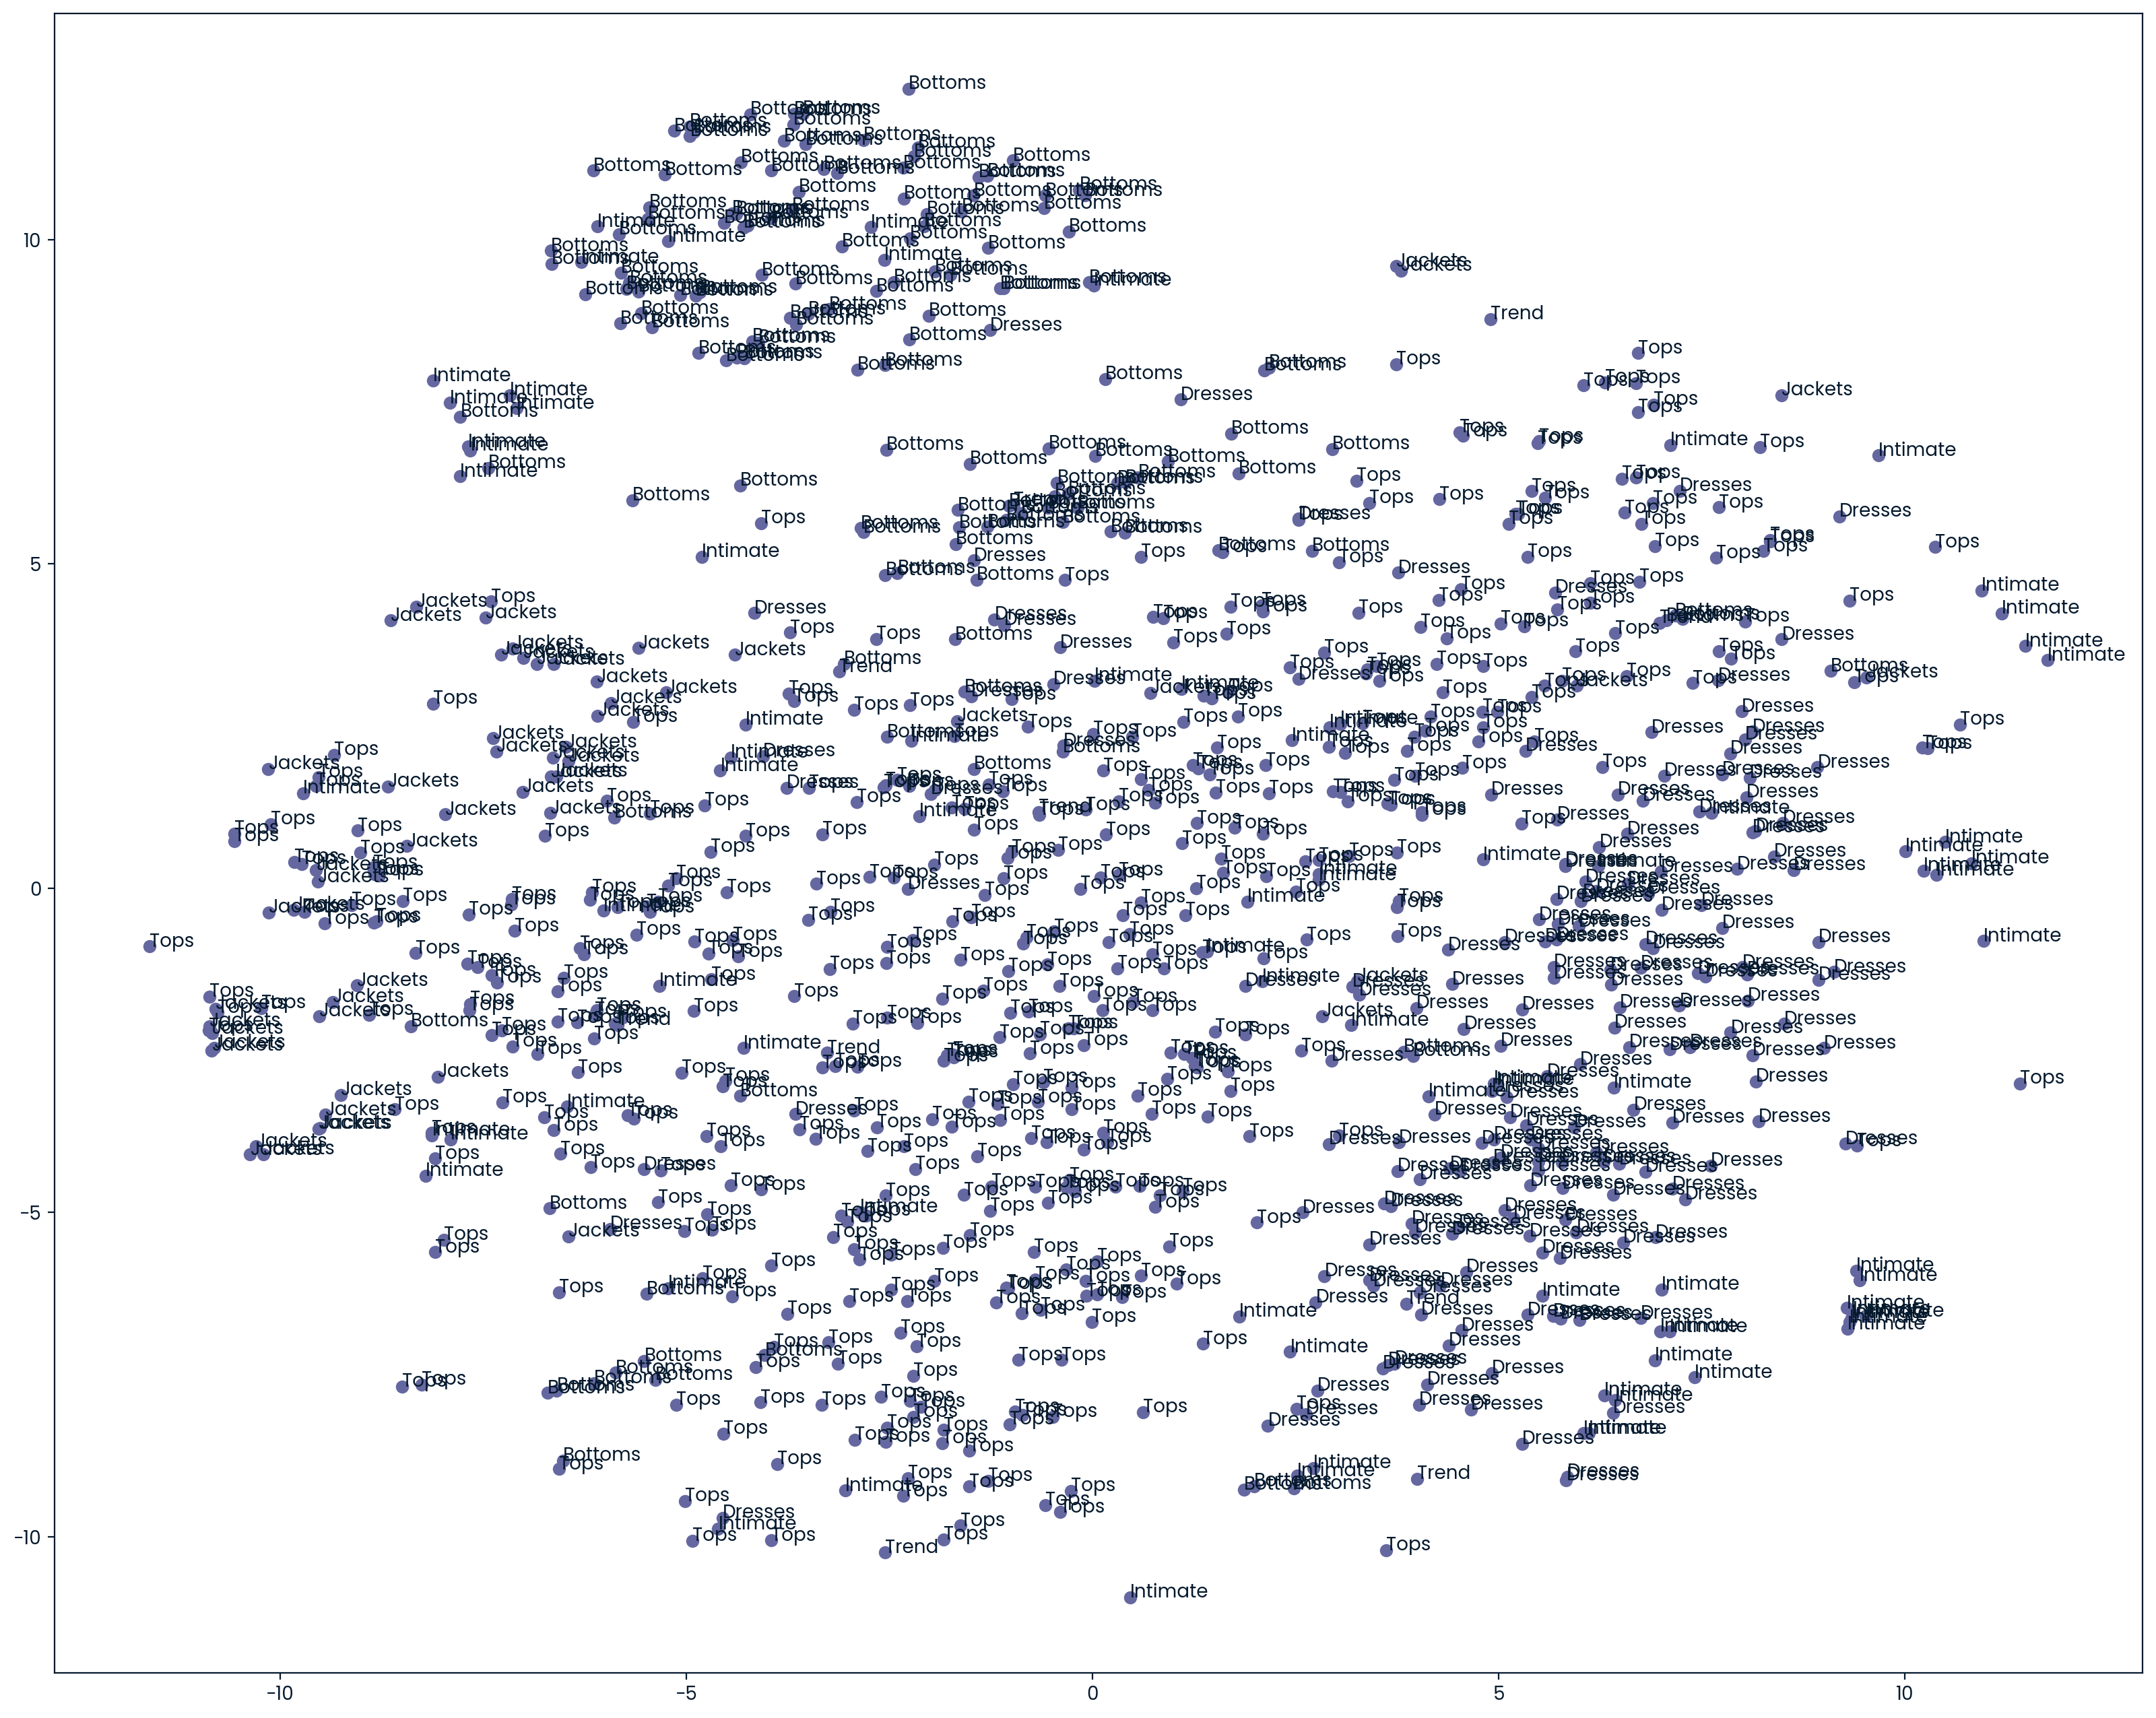

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# Section 2 : Dimensionality reduction & visualization

# Part 1: converting embeddings to 2d format

# No of data points = 958. Hence perplixity must be < 958.
tsne = TSNE(n_components=2, perplexity=100)

embeddings_2d = tsne.fit_transform(np.array(embeddings))

# Part 2: Plotting the 2d embeddings

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 16))

plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])

categories = [cat for cat in reviews['Department Name']]

for i, cat in enumerate(categories):
    plt.annotate(cat, (embeddings_2d[i,0], embeddings_2d[i,1]))

plt.show()

### ✅ Results
- **Successfully visualized 958 reviews** in 2D space
- Clear clustering patterns emerged by product department (Tops, Bottoms, Dresses, Jackets, Intimate)
- Similar reviews grouped together spatially
- Enables visual identification of distinct customer sentiment zones
---

### Section 3: Feedback Categorization

### 🎯 Objective
Identify reviews discussing specific topics (e.g., "fit") using semantic similarity search.

### 🔧 Approach
1. **Generate topic embedding** for the query term (e.g., "fit")
2. **Calculate cosine similarity** between topic embedding and all review embeddings
3. **Find minimum distance** to retrieve the most relevant review


In [ ]:
from scipy.spatial import distance

# Section 3: Feedback categorization

topic = "fit"

#1 find the query embedding
response = client.embeddings.create(
    model="text-embedding-3-small",
    input=topic
)
response_dict = response.model_dump()
topic_embedding = response_dict['data'][0]['embedding']

#2 iterate over the embeddings list, caluclate the distance and save them in a list
distances = []

for embd in embeddings:
    dist = distance.cosine(topic_embedding,embd)
    distances.append(dist)

#3 find the feedback which has the least corresponding distance to the query
min_distance = np.argmin(distances)
reviews.iloc[min_distance]


Review ID                                                                467
Clothing ID                                                             1078
Age                                                                       61
Title                                                   Great sweater dress!
Review Text                Nice fit and flare style, not clingy at all. i...
Rating                                                                     5
Recommended IND                                                            1
Positive Feedback Count                                                    1
Division Name                                                        General
Department Name                                                      Dresses
Class Name                                                           Dresses
Name: 467, dtype: object

### ✅ Results
**Most relevant review for "fit":**
- Review: *"Nice fit and flare style, not clingy at all..."*
- Department: Dresses
- Rating: 5/5
- Successfully identified a review specifically discussing fit quality

---

### Section 4: Similarity Search Function

#### 🎯 Objective
Build a function that finds the 3 most similar reviews to any given input, enabling personalized customer service responses.

#### 🔧 Approach
1. **Create structured text** from review metadata (ID, rating, department, etc.)
2. **Embed input review** using OpenAI API
3. **Calculate cosine distances** between input and all review embeddings
4. **Sort and return top 3** most similar reviews


In [ ]:
# Section 4: Recomendation system

def create_text(review):
    return f"""
    Review ID: {review['Review ID']}
    Clothing ID: {review['Clothing ID']}
    Age: {review['Age']}
    Title: {review['Title']}
    Review Text: {review['Review Text']}
    Rating: {review['Rating']}/5
    Recommended: {'Yes' if review['Recommended IND'] == 1 else 'No'}
    Positive Feedback: {review['Positive Feedback Count']}
    Division: {review['Division Name']}
    Department: {review['Department Name']}
    Class: {review['Class Name']}
    """

In [61]:
query_review = reviews.iloc[0]

all_review_texts = [create_text(row) for _, row in reviews.iterrows()]
    
response = client.embeddings.create(
    model="text-embedding-3-small",
    input=all_review_texts
    )
    
response_dict = response.model_dump()
all_review_embeddings = [data['embedding'] for data in response_dict['data']]


In [62]:
def closest_3_reviews(input_review, embeddings, n=3):

    input_text = create_text(input_review)
    
    response = client.embeddings.create(
    model="text-embedding-3-small",
    input=input_text
    )
    
    response_dict = response.model_dump()
    input_embedding = response_dict['data'][0]['embedding']

    distances = []

    for i, embd in enumerate(embeddings):
        dist = distance.cosine(input_embedding,embd)
        distances.append({'distance':dist,'index':i})

    distances_sorted = sorted(distances, key= lambda x: x['distance'])
    hits = distances_sorted[0:n]

    result = []

    for hit in hits:
        result.append(reviews.iloc[hit['index']]['Review Text'])
        # display(reviews.iloc[[hit['index']]])

    return result

In [63]:
most_similar_reviews = closest_3_reviews(query_review,all_review_embeddings)

print(most_similar_reviews)

['Absolutely wonderful - silky and sexy and comfortable', 'I was initially attracted to the colors', 'Love love love these leggings and what an amazing price point!!!']


#### ✅ Results
**Query:** *"Absolutely wonderful - silky and sexy and comfortable"*

**Top 3 Similar Reviews:**
1. *"Absolutely wonderful - silky and sexy and comfortable"* (Self-match ✓)
2. *"I was initially attracted to the colors"*
3. *"Love love love these leggings and what an amazing price point!!!"*

Successfully identifies semantically similar reviews with positive sentiment and comfort/quality themes.

### 🔑 Key Application
This similarity search function enables:
- **Automated response suggestions** for customer service teams
- **Pattern detection** in customer complaints or praise
- **Personalized recommendations** based on similar customer experiences

Function is reusable for any review input, making it production-ready for real-world applications.